In [1]:
from tensorflow import keras
from keras.datasets import mnist
from keras import models, layers, optimizers

import numpy as np
from PIL import Image
import math
import os

import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_first')
print(K.image_data_format)

<function image_data_format at 0x7fc6a107fd90>


In [3]:
def mse_4d(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=(1, 2, 3))

def mse_4d_tf(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true), axis=(1, 2, 3))

In [4]:
import argparse

def main():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--batch_size', type=int, default=16, help='Batch size for the networks')
    parser.add_argument('--epochs', type=int, default=1000, help='Epochs for the networks')
    parser.add_argument('--output_fold', type=str, default='GAN_OUT', help='Output fold to save the results')
    parser.add_argument('--input_dim', type=int, default=10, help='Input dimension for the generator')
    parser.add_argument('--n_train', type=int, default=32, help='The number of training data')
    
    args = parser.parse_args()
    train(args)

In [5]:
#from tensorflow.python.keras import Sequential

#class GAN(models.Sequential):
class GAN():
    def __init__(self, input_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.generator = self.GENERATOR()
        self.discriminator = self.DISCRIMINATOR()
        self.generator_discriminator = self.GENERATOR_DISCRIMINATOR()
        #self.add(self.generator)
        #self.discriminator.trainable = False
        #self.add(self.discriminator)
        
        self.compile_all()
    
    def GENERATOR_DISCRIMINATOR(self):
        model = models.Sequential()
        model.add(self.generator)
        self.discriminator.trainable = False
        model.add(self.discriminator)
        print('GENERATOR_DISCRIMINATOR summary()')
        model.summary()
        return model
    
    def compile_all(self):
        d_optim = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)
        g_optim = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)
        self.generator.compile(loss=mse_4d_tf, optimizer='SGD')
        #self.compile(loss='binary_crossentropy', optimizer=g_optim)
        self.generator_discriminator.compile(loss='binary_crossentropy', optimizer=g_optim)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
        
    def GENERATOR(self):
        input_dim = self.input_dim
        model = models.Sequential()
        model.add(layers.Dense(1024, activation='tanh', input_dim=input_dim))
        model.add(layers.Dense(128 * 7 * 7, activation='tanh'))
        model.add(layers.BatchNormalization())
        model.add(layers.Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(64, (5, 5), padding='same', activation='tanh'))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(1, (5, 5), padding='same', activation='tanh'))
        print('GENERATOR summary()')
        model.summary()

        return model
    
    def DISCRIMINATOR(self):
        model = models.Sequential()
        model.add(layers.Conv2D(64, (5, 5), padding='same', activation='tanh', input_shape=(1, 28, 28)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(128, (5, 5), activation='tanh'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(1024, activation='tanh'))
        model.add(layers.Dense(1, activation='sigmoid'))
        print('DISCRIMINATOR summary()')
        model.summary()

        return model
    
    def get_z(self, ln):
        input_dim = self.input_dim
        return np.random.uniform(-1, 1, (ln, input_dim))
    
    def train_both(self, x):
        ln = x.shape[0]
        z = self.get_z(ln)
        w = self.generator.predict(z, verbose=0)
        xw = np.concatenate((x, w))
        y2 = [1] * ln + [0] * ln
        d_loss = self.discriminator.train_on_batch(xw, y2)
        #print(self.discriminator.metrics_names)
        
        z = self.get_z(ln)
        self.discriminator.trainable = False
        #g_loss = self.train_on_batch(z, [1] * ln)
        g_loss = self.generator_discriminator.train_on_batch(z, [1] * ln)
        #print(self.generator_discriminator.metrics_names)
        self.discriminator.trainable = True
        return d_loss, g_loss
    

In [6]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[2:]
    image = np.zeros((height * shape[0], width * shape[1]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]:(i+1)* shape[0], j * shape[1]:(j+1)*shape[1]] = img[0, : , :]
    return image

def get_x(X_train, index, BATCH_SIZE):
    return X_train[index * BATCH_SIZE:(index +1)*BATCH_SIZE]

def save_images(generated_images, output_fold, epoch, index):
    image = combine_images(generated_images)
    image = image * 127.5 + 127.5
    Image.fromarray(image.astype(np.uint8)).save(output_fold + '/' + str(epoch) + '_' + str(index) + '.png')
    
def load_data(n_train):
    (X_train, y_train), (_, _) = mnist.load_data()
    return X_train[:n_train]

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(output_fold, epoch, index):
    image = mpimg.imread(output_fold + '/' + str(epoch) + '_' + str(index) + '.png')
    plt.imshow(image)
    plt.show()


In [8]:

def train(batch_size, epochs, output_fold, input_dim, n_train):
    BATCH_SIZE = batch_size
    
    #BATCH_SIZE = args.batch_size
    #epochs = args.epochs
    #output_fold = args.output_fold
    #input_dim = args.input_dim

    os.makedirs(output_fold, exist_ok=True)
    os.makedirs(output_fold + '/weights', exist_ok=True)
    print('output_fold is ', output_fold)
    
    X_train = load_data(n_train)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
    
    gan = GAN(input_dim)
    
    d_loss_ll = []
    g_loss_ll = []
    for epoch in range(epochs):
        if epoch % 100 == 0 or epoch == epochs -1:
            print('Epoch is', epoch)
            print('Number of batches', int(X_train.shape[0] / BATCH_SIZE))
        
        d_loss_l = []
        g_loss_l = []
        for index in range(int(X_train.shape[0] / BATCH_SIZE)):
            x = get_x(X_train, index, BATCH_SIZE)
            d_loss, g_loss = gan.train_both(x)
            
            d_loss_l.append(d_loss)
            g_loss_l.append(g_loss)
        
        if epoch % 100 == 0 or epoch == epochs -1:
            z = gan.get_z(x.shape[0])
            w = gan.generator.predict(z, verbose=0)
            save_images(w, output_fold, epoch, index)
            show_images(output_fold, epoch, index)
            
        
        d_loss_ll.append(d_loss_l)
        g_loss_ll.append(g_loss_l)
        
        gan.generator.save_weights(output_fold + '/weights/' + 'generator', True)
        gan.discriminator.save_weights(output_fold + '/weights/' + 'discriminator', True)
        
        np.savetxt(output_fold + '/' + 'd_loss', d_loss_ll)
        np.savetxt(output_fold + '/' + 'g_loss', g_loss_ll)

output_fold is  GAN_OUT




GENERATOR summary()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              11264     
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
up_sampling2d_2 (UpSampling2

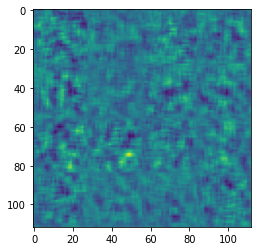

Epoch is 100
Number of batches 2


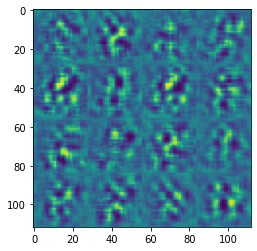

Epoch is 200
Number of batches 2


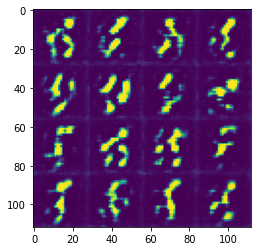

Epoch is 300
Number of batches 2


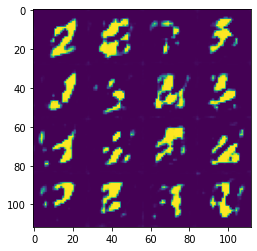

Epoch is 400
Number of batches 2


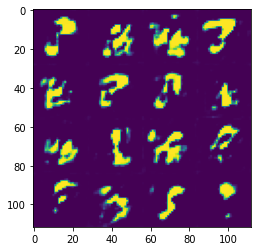

Epoch is 500
Number of batches 2


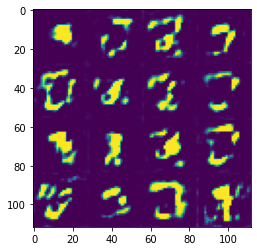

Epoch is 600
Number of batches 2


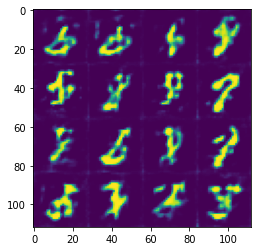

Epoch is 700
Number of batches 2


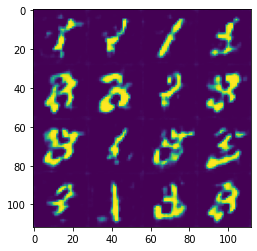

Epoch is 800
Number of batches 2


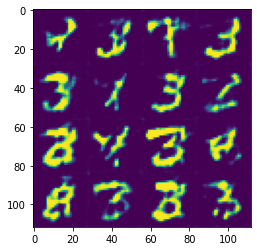

Epoch is 900
Number of batches 2


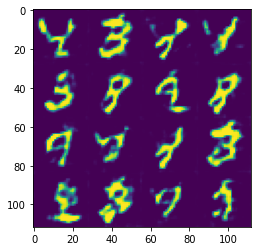

Epoch is 1000
Number of batches 2


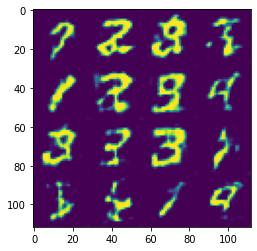

Epoch is 1100
Number of batches 2


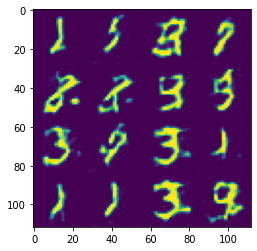

Epoch is 1200
Number of batches 2


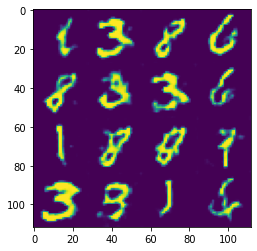

Epoch is 1300
Number of batches 2


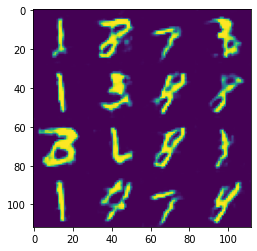

Epoch is 1400
Number of batches 2


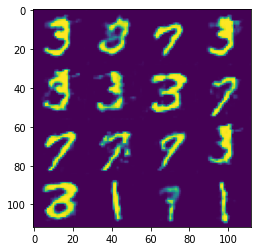

Epoch is 1500
Number of batches 2


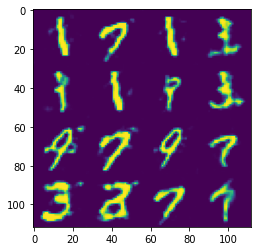

Epoch is 1600
Number of batches 2


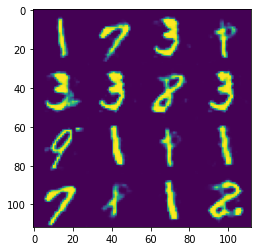

Epoch is 1700
Number of batches 2


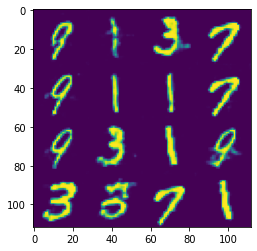

Epoch is 1800
Number of batches 2


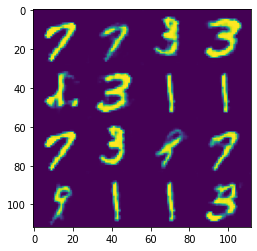

Epoch is 1900
Number of batches 2


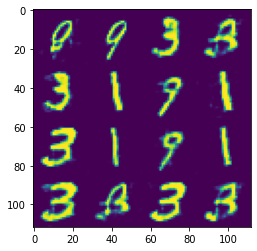

Epoch is 2000
Number of batches 2


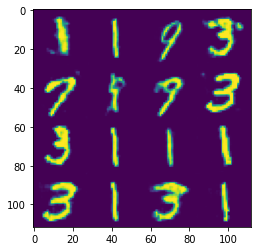

Epoch is 2100
Number of batches 2


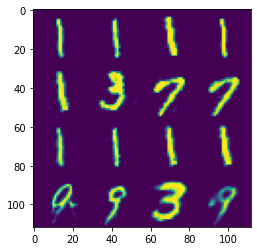

Epoch is 2200
Number of batches 2


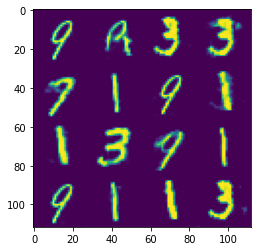

Epoch is 2300
Number of batches 2


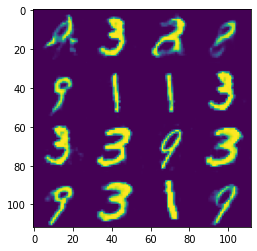

Epoch is 2400
Number of batches 2


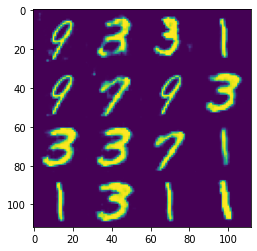

Epoch is 2500
Number of batches 2


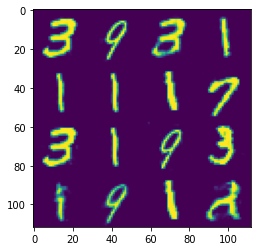

Epoch is 2600
Number of batches 2


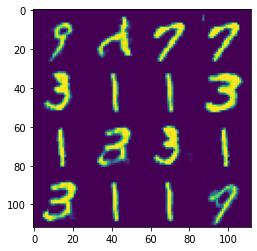

Epoch is 2700
Number of batches 2


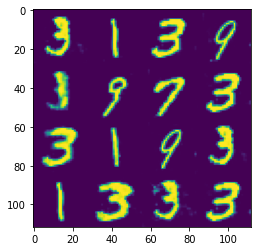

Epoch is 2800
Number of batches 2


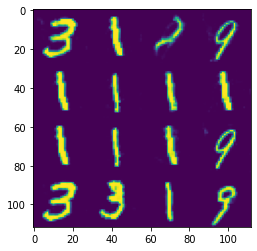

Epoch is 2900
Number of batches 2


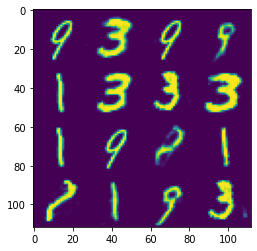

Epoch is 3000
Number of batches 2


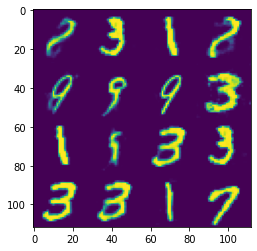

Epoch is 3100
Number of batches 2


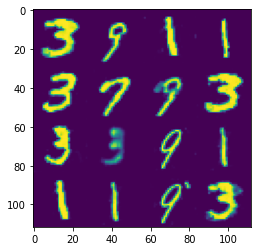

Epoch is 3200
Number of batches 2


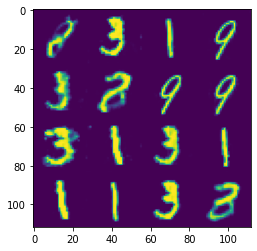

Epoch is 3300
Number of batches 2


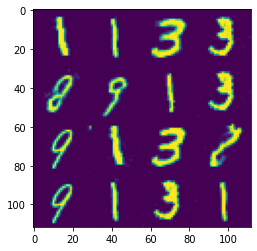

Epoch is 3400
Number of batches 2


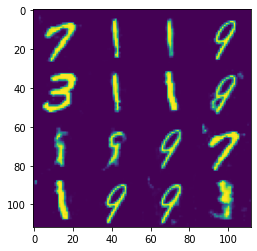

Epoch is 3500
Number of batches 2


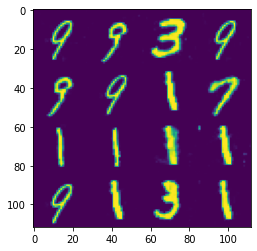

Epoch is 3600
Number of batches 2


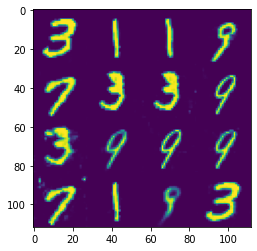

Epoch is 3700
Number of batches 2


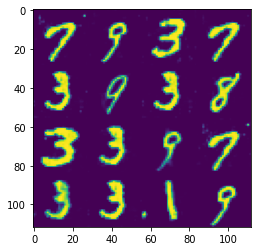

Epoch is 3800
Number of batches 2


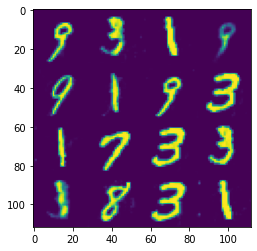

Epoch is 3900
Number of batches 2


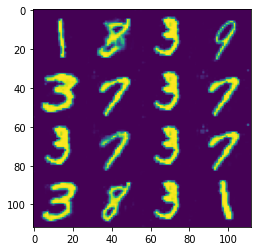

Epoch is 4000
Number of batches 2


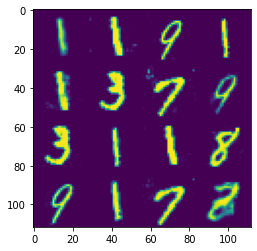

Epoch is 4100
Number of batches 2


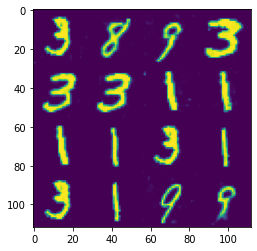

Epoch is 4200
Number of batches 2


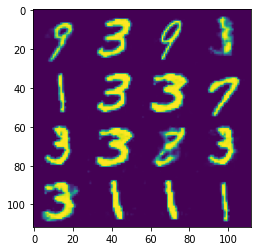

Epoch is 4300
Number of batches 2


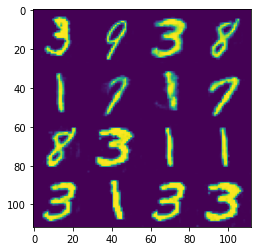

Epoch is 4400
Number of batches 2


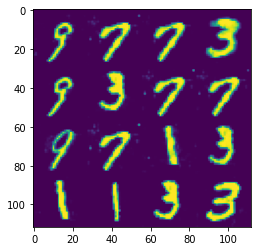

Epoch is 4500
Number of batches 2


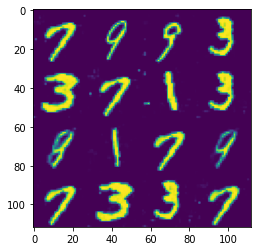

Epoch is 4600
Number of batches 2


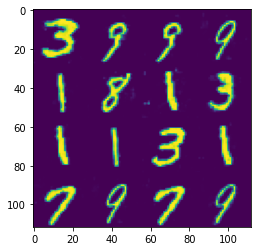

Epoch is 4700
Number of batches 2


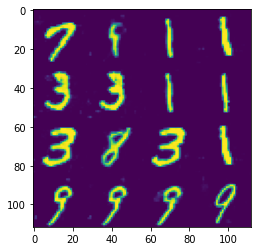

Epoch is 4800
Number of batches 2


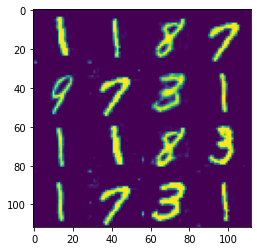

Epoch is 4900
Number of batches 2


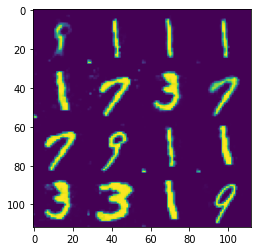

KeyboardInterrupt: 

In [9]:
#main()
train(batch_size=16, epochs=10000, output_fold='GAN_OUT', input_dim=10, n_train=32)

In [10]:
tf.__version__

'1.15.2'

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10776486408790123788
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7107470832504302994
physical_device_desc: "device: XLA_CPU device"
]


In [11]:
X_train = load_data(32)

In [12]:
X_train.shape

(32, 28, 28)

In [13]:
X_train[0:16].shape

(16, 28, 28)

output_fold is  GAN_OUT
GENERATOR summary()
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              11264     
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
up_samplin

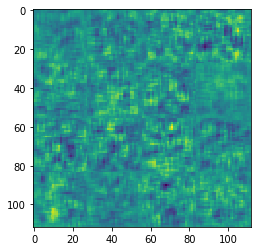

Epoch is 100
Number of batches 2


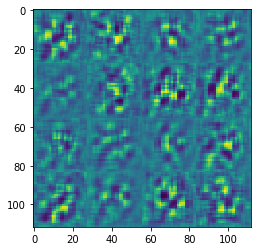

Epoch is 200
Number of batches 2


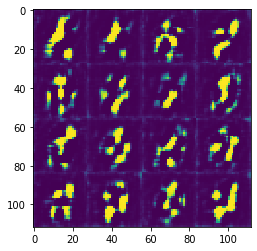

Epoch is 300
Number of batches 2


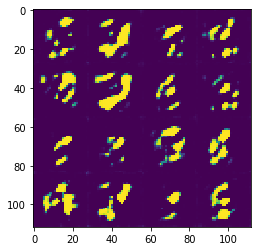

Epoch is 400
Number of batches 2


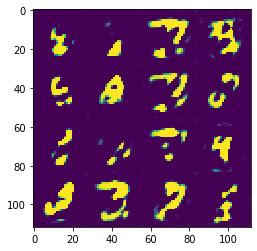

Epoch is 500
Number of batches 2


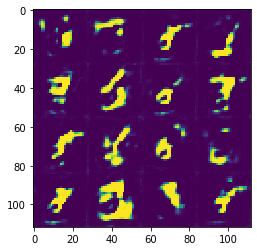

Epoch is 600
Number of batches 2


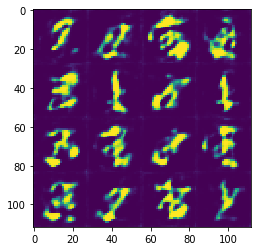

Epoch is 700
Number of batches 2


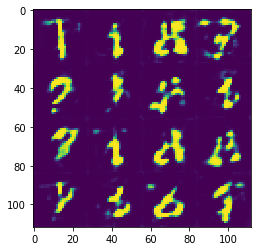

Epoch is 800
Number of batches 2


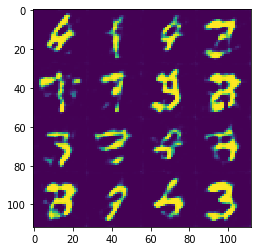

Epoch is 900
Number of batches 2


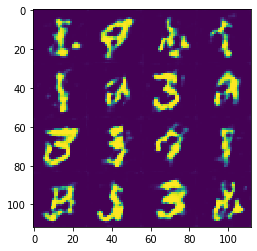

Epoch is 999
Number of batches 2


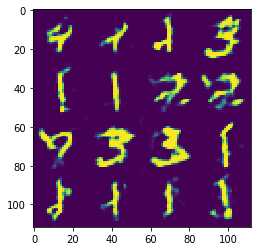

In [14]:
train(batch_size=16, epochs=1000, output_fold='GAN_OUT', input_dim=10, n_train=32)

In [ ]:
train(batch_size=16, epochs=100, output_fold='GAN_OUT', input_dim=10, n_train=32)